# Analýza tramvají PID

Použiji data [jízdních řádů PID](https://pid.cz/o-systemu/opendata/#h-gtfs). Zaměřím se na tramvaje, vizualizuji tramvajovou síť, prozkoumám důležitost zastávek pomocí různých centralit a nakonec zodpovím vybrané otázky.

Soubor `d.csv` nahraný na GitHub je z důvodu velké velikosti zkrácená verze souboru, který jsem použil. Proto je možné, že při spuštění tohoto notebooku budou výsledky rozdílné, některé zastávky mohou chybět.

In [1]:
%matplotlib inline

import collections
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import re
import math
import json

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns

import pandas as pd
import numpy as np
import networkx as nx
from tqdm import tqdm

mpl.rcParams['figure.dpi']=200

# Příprava dat

Data načtu a zbavím se sloupců *stop_from* a *stop_to* s identifikátory zastávek, jako identifikátor mi budou stačit jména zastávek. Také upravím sloupce *depart_from* a *arrive_to*, aby čas byl v rozmezí 0:00:00 až 23:59:59. Navíc vytvořím nový sloupec *num_days* s počtem dní, kdy daný spoj jezdí. To se bude hodit u výpočtu vah hran.

In [2]:
df = pd.read_csv("d.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0


In [3]:
def normalize_time(time_string):
    h, m, s = time_string.split(":")
    h = str(int(h) % 24)
    return f"{h}:{m}:{s}"

df = df.drop(["stop_from", "stop_to"], axis=1)

df["depart_from"] = df["depart_from"].apply(normalize_time)
df["arrive_to"] = df["arrive_to"].apply(normalize_time)

df["num_days"] = df[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].sum(axis=1)
df.head()

,stop_from_name,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday,num_days
0,Hněvice,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0,5
1,Hněvice seř.n.,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0,5
2,Záluží,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0,5
3,Dobříň,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0,5
4,Roudnice nad Labem,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0,5


# Základní síťová analýza

Budu používat NetworkX a zaměřím se pouze na tramvaje [(*route_type* == 0)](https://gtfs.org/documentation/schedule/reference/#routestxt).

## Vizualizace sítě

Nejprve si vytvořím nový dataset, ve kterém budou jen záznamy o tramvajích. Pak už můžu vytvořit orientovaný graf. Vrcholy budou reprezentovat zastávky a hrany budou reprezentovat spoje mezi sousedními zastávkami. Váha hrany je počet tramvají, které danou trasu projedou během jednoho týdne.

In [4]:
tram_df = df[df["route_type"] == 0]

edges = tram_df[["stop_from_name", "stop_to_name", "num_days"]].groupby(["stop_from_name", "stop_to_name"]).sum().reset_index()
vertices = set(edges["stop_from_name"]).union(set(edges["stop_to_name"]))

G = nx.DiGraph()
G.add_nodes_from(vertices)
for index, row in edges.iterrows():
    G.add_edge(row["stop_from_name"], row["stop_to_name"], weight=row["num_days"])

K vykreslení grafu použiji zeměpisnou polohu zastávek ze souboru `stops.txt`. V tom se vyskytují některé zastávky se stejným jménem vícekrát (pro různé dopravní prostředky), v takovém případě budu používat průměrnou zeměpisnou šířku a délku. To ničemu nevadí, jelikož takové zastávky jsou obvykle velmi blízko sebe, takže na obrázku grafu může být některá zastávka trochu posunutá, ale vzájemná poloha zastávek zůstane zachována.

In [5]:
vertex_pos = pd.read_csv("stops.txt")[["stop_name", "stop_lat", "stop_lon"]].dropna(how="any")
vertex_pos = vertex_pos.groupby("stop_name").mean()
vertex_pos = vertex_pos[["stop_lon", "stop_lat"]].to_dict(orient="index")
vertex_pos = {stop_name: [val["stop_lon"], val["stop_lat"]] for stop_name, val in vertex_pos.items() if stop_name in vertices}

Teď už můžu vykreslit graf. Popsané budou jen konečné zastávky (vrcholy mající jen jednoho souseda). Tloušťka hrany bude odpovídat frekvenci spoje.

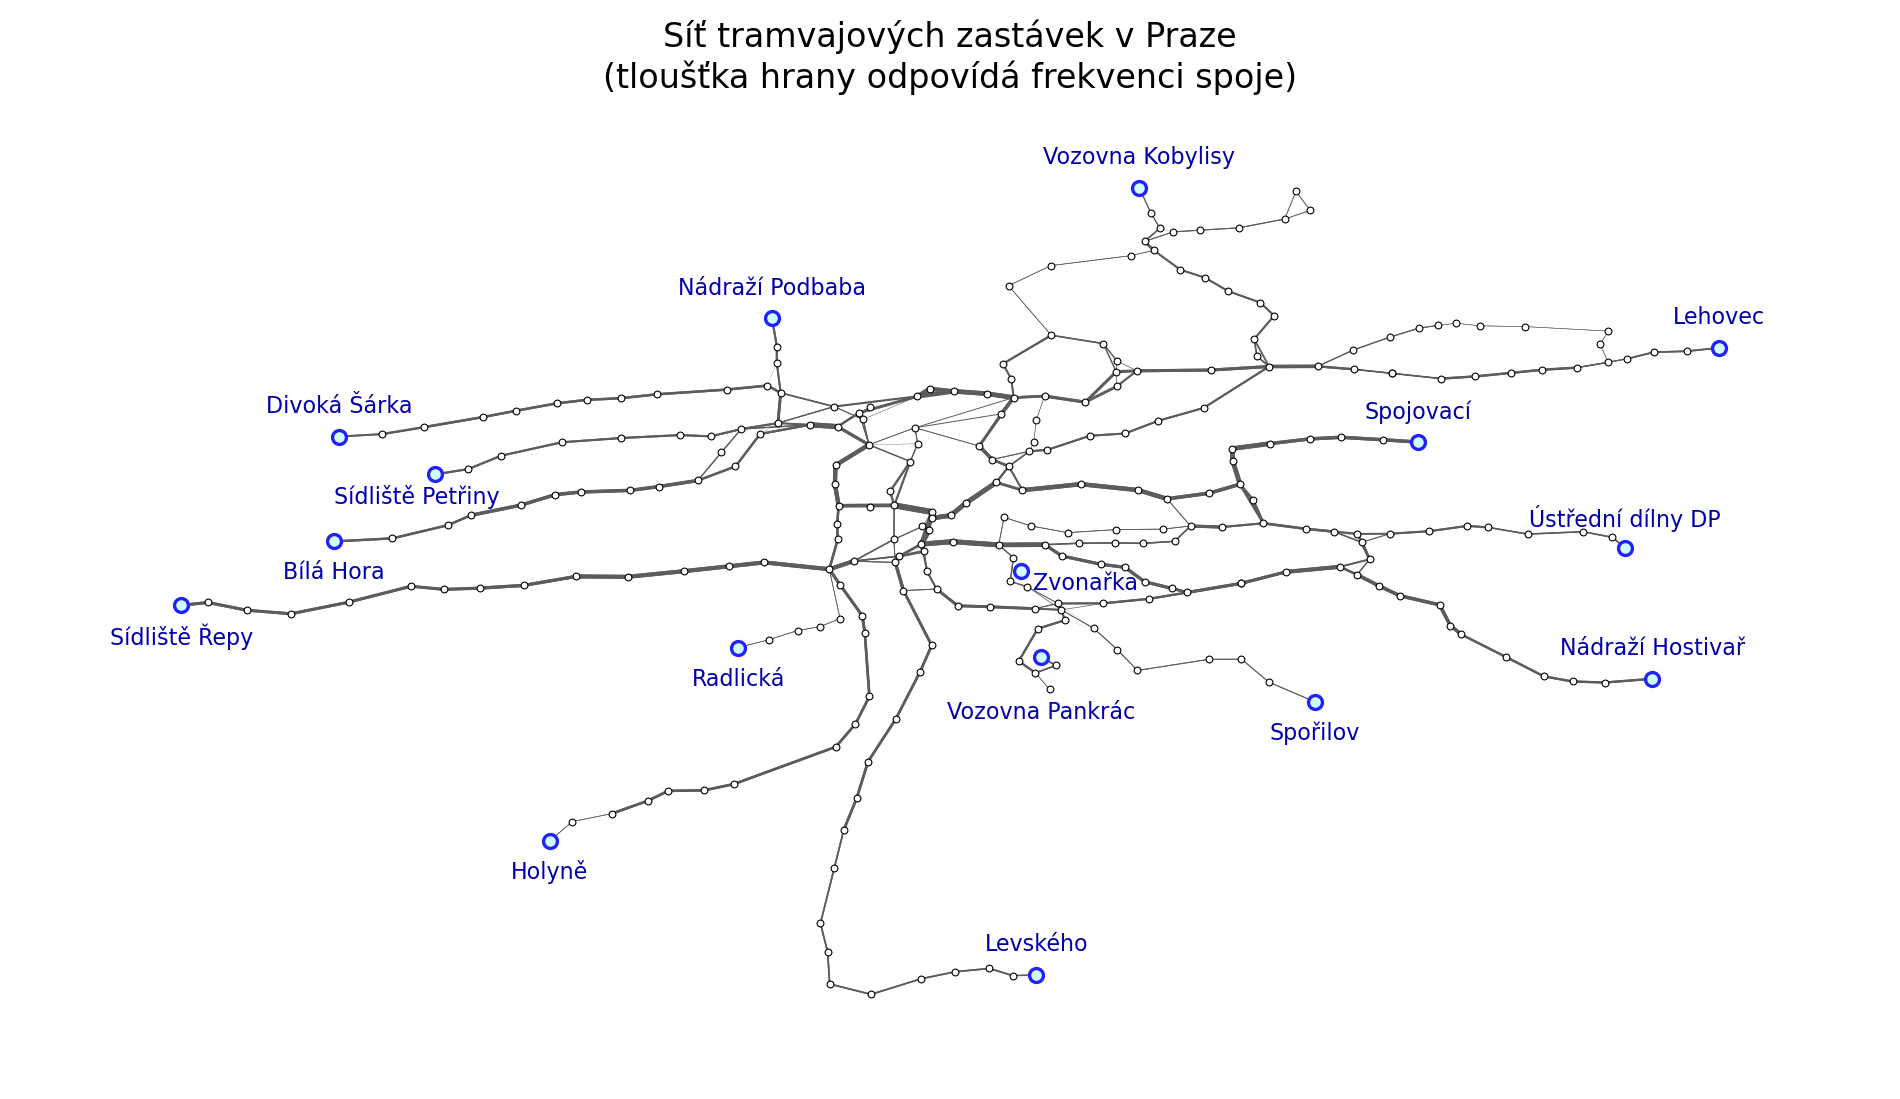

In [6]:
all_stops = set([name for name in G.nodes])
final_stops = set([name for name, degree in G.in_degree if degree <= 1]).intersection(set([name for name, degree in G.out_degree if degree <= 1]))
to_remove = []
for stop in final_stops:
    if len(set(G.successors(stop)).union(set(G.predecessors(stop)))) >= 2:
        to_remove.append(stop)
for stop in to_remove:
    final_stops.remove(stop)
other_stops = all_stops.difference(final_stops)
node_labels = {name: name for name in final_stops}
labels_pos = {node: [x, y + 0.005] for node, (x, y) in vertex_pos.items()}
for name in ("Spořilov", "Bílá Hora", "Sídliště Řepy", "Holyně", "Radlická", "Sídliště Barrandov"):
    labels_pos[name][1] -= 0.01
labels_pos["Vozovna Pankrác"][1] -= 0.014
labels_pos["Sídliště Petřiny"][1] -= 0.0085
labels_pos["Sídliště Petřiny"][0] -= 0.003
labels_pos["Zvonařka"][1] -= 0.007
labels_pos["Zvonařka"][0] += 0.0105

edge_weights = [attr["weight"] for u, v, attr in G.edges(data=True)]
min_weight, max_weight = min(edge_weights), max(edge_weights)
edge_widths = [((weight - min_weight) / (max_weight - min_weight)) * 2.2 for weight in edge_weights]

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_aspect("equal")
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)

nx.draw_networkx_nodes(G, pos=vertex_pos, nodelist=other_stops, node_size=6, node_color="#ffffff", edgecolors="black", linewidths=0.4)
nx.draw_networkx_nodes(G, pos=vertex_pos, nodelist=final_stops, node_size=25, node_color="#d1fffc", edgecolors="#2222ff", linewidths=1.2)
nx.draw_networkx_edges(G, pos=vertex_pos, width=edge_widths, edge_color="#5c5c5c", node_size=6, arrows=False)
nx.draw_networkx_labels(G, pos=labels_pos, labels=node_labels, font_size=8, font_color="#0000aa")

ax.set_title("Síť tramvajových zastávek v Praze\n(tloušťka hrany odpovídá frekvenci spoje)");

## Míry centrality

Nyní prozkoumám důležitost zastávek pomocí měr centrality.

### Stupňová centralita

Začnu stupňovou centralitou, ta vyjadřuje, kolik sousedů (sousedních zastávek) má nějaký vrchol (zastávka) ku celkovému počtu vrcholů. Podívám se na zastávky s nejvyšší stupňovou centralitou pro celkový stupeň, vstupní stupeň i výstupní stupeň.

In [7]:
deg_centrality = nx.degree_centrality(G)
indeg_centrality = nx.in_degree_centrality(G)
outdeg_centrality = nx.out_degree_centrality(G)

deg_centrality_sorted = sorted(deg_centrality.items(), key=lambda x: x[1], reverse=True)
indeg_centrality_sorted = sorted(indeg_centrality.items(), key=lambda x: x[1], reverse=True)
outdeg_centrality_sorted = sorted(outdeg_centrality.items(), key=lambda x: x[1], reverse=True)

value_cap = deg_centrality_sorted[4][1]
print("Zastávky s nejvyššími hodnotami stupňové centrality (vstupní i výstupní stupně)")
for name, value in deg_centrality_sorted:
    if value < value_cap:
        break
    print(f"  - {name}: {value:.5f}")
    print(f"    Stupeň: {G.degree()[name]}")
    
value_cap = indeg_centrality_sorted[4][1]
print("\nZastávky nejvyššími hodnotami stupňové centrality (pouze vstupní stupně)")
for name, value in indeg_centrality_sorted:
    if value < value_cap:
        break
    print(f"  - {name}: {value:.5f}")
    print(f"    Vstupní stupeň: {G.in_degree()[name]}")
    
value_cap = outdeg_centrality_sorted[4][1]
print("\nZastávky nejvyššími hodnotami stupňové centrality (pouze výstupní stupně)")
for name, value in outdeg_centrality_sorted:
    if value < value_cap:
        break
    print(f"  - {name}: {value:.5f}")
    print(f"    Výstupní stupeň: {G.out_degree()[name]}")

Zastávky s nejvyššími hodnotami stupňové centrality (vstupní i výstupní stupně)
  - Malostranská: 0.04643
    Stupeň: 13
  - Náměstí Bratří Synků: 0.04286
    Stupeň: 12
  - Otakarova: 0.04286
    Stupeň: 12
  - Prašný most: 0.03571
    Stupeň: 10
  - Vozovna Střešovice: 0.03571
    Stupeň: 10
  - Anděl: 0.03571
    Stupeň: 10
  - Národní divadlo: 0.03571
    Stupeň: 10

Zastávky nejvyššími hodnotami stupňové centrality (pouze vstupní stupně)
  - Malostranská: 0.02500
    Vstupní stupeň: 7
  - Náměstí Bratří Synků: 0.02143
    Vstupní stupeň: 6
  - Otakarova: 0.02143
    Vstupní stupeň: 6
  - Karlovo náměstí: 0.02143
    Vstupní stupeň: 6
  - Prašný most: 0.01786
    Vstupní stupeň: 5
  - Strossmayerovo náměstí: 0.01786
    Vstupní stupeň: 5
  - Vozovna Střešovice: 0.01786
    Vstupní stupeň: 5
  - Anděl: 0.01786
    Vstupní stupeň: 5
  - Národní divadlo: 0.01786
    Vstupní stupeň: 5

Zastávky nejvyššími hodnotami stupňové centrality (pouze výstupní stupně)
  - Náměstí Bratří Synků: 0

V první kategorii jsou zastávky, které mají hodně sousedních zastávek. Ve druhé kategorii jsou zastávky, do kterých se dostanu z mnoha sousedních zastávek. A ve třetí jsou zastávky, ze kterých se dostanu do mnoha sousedních zastávek. Na prvním místě ve všech kategoriích je Malostranská. Povšimněme si, že některé zastávky mají rozdílný vstupní a výstupní stupeň, jsou tedy v nějakém směru jednosměrné.

### Centralita blízkosti

Centralita blízkosti nám říká, jak blízko je vrchol od všech ostatních.

In [8]:
closeness_centrality = nx.closeness_centrality(G)
closeness_centrality_sorted = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

value_cap = closeness_centrality_sorted[4][1]
print("Zastávky s nejvyššími hodnotami centrality blízkosti")
for name, value in closeness_centrality_sorted:
    if value < value_cap:
        break
    print(f"  - {name}: {value:.5f}")

Zastávky s nejvyššími hodnotami centrality blízkosti
  - Malostranská: 0.09625
  - Staroměstská: 0.09543
  - Čechův most: 0.09488
  - Strossmayerovo náměstí: 0.09374
  - Právnická fakulta: 0.09318


Zde můžeme vidět zastávky, ze kterých se lze dostat do všech ostatních na co nejkratší vzdálenost (slovem "vzdálenost" je myšlen co nejmenší počet zastávek). I zde je Malostranská na prvním místě.

### Centralita mezilehlosti

Centralita mezilehlosti nám říká, jak často je vrchol součástí nejkratší cesty mezi jinými dvěma vrcholy.

In [9]:
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_sorted = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

value_cap = betweenness_centrality_sorted[4][1]
print("Zastávky s nejvyššími hodnotami centrality mezilehlosti")
for name, value in betweenness_centrality_sorted:
    if value < value_cap:
        break
    print(f"  - {name}: {value:.5f}")

Zastávky s nejvyššími hodnotami centrality mezilehlosti
  - Malostranská: 0.34112
  - Národní divadlo: 0.28091
  - Čechův most: 0.27098
  - Staroměstská: 0.26699
  - Strossmayerovo náměstí: 0.25079


Tyto zastávky se nejčastěji vyskytují na nejkratší cestě mezi jinými zastávkami (délka cesty odpovídá počtu zastávek). Dávalo by smysl, kdyby se jednalo spíše o zastávky v centru, pojďme se podívat na vizualizaci.

Malostranská je podle všech tří měr centrality na prvním místě, bude to nejspíše důležitá zastávka.

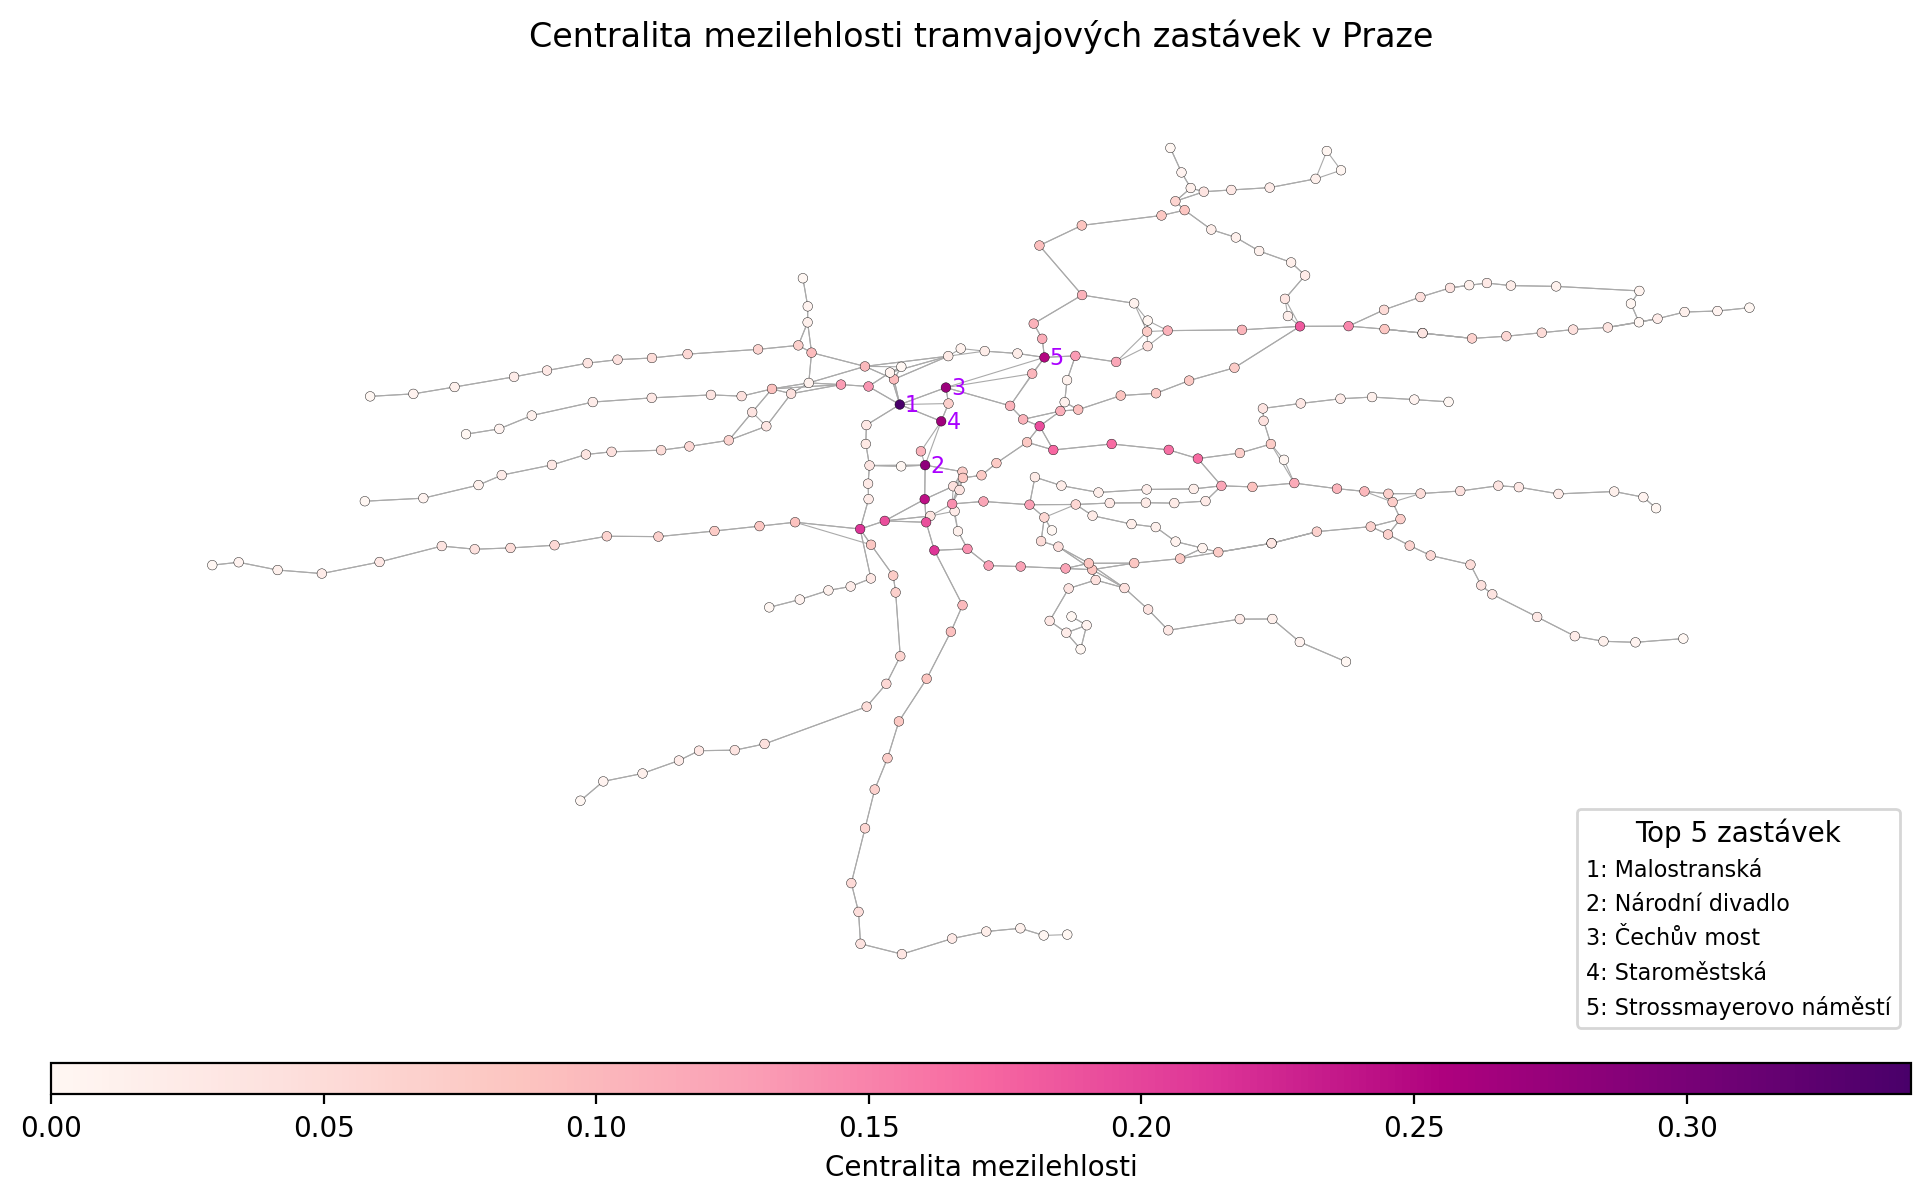

In [10]:
cmap = cm.get_cmap("RdPu")
norm = mcolors.Normalize(vmin=min(betweenness_centrality.values()), vmax=max(betweenness_centrality.values()))
node_colors = [cmap(norm(value)) for value in betweenness_centrality.values()]
betweenness_labels = {name: i + 1 for i, (name, val) in enumerate(betweenness_centrality_sorted[:5])}
betweenness_pos = {node: [x + 0.002, y] for node, (x, y) in vertex_pos.items()}

legend_handles = [mpl.patches.Patch(label=f"{i + 1}: {name}") for i, (name, val) in enumerate(betweenness_centrality_sorted[:5])]

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_aspect("equal")
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label="Centralita mezilehlosti", orientation="horizontal", pad=0.02, aspect=60)
nx.draw_networkx_nodes(G, pos=vertex_pos, node_color=node_colors, edgecolors="black", linewidths=0.15, node_size=12)
nx.draw_networkx_edges(G, pos=vertex_pos, arrowsize=5, width=0.4, edge_color="#aaaaaa", node_size=12, arrows=False)
nx.draw_networkx_labels(G, pos=betweenness_pos, labels=betweenness_labels, font_size=8, font_color="#aa00ff")
ax.legend(handles=legend_handles, loc="lower right", title="Top 5 zastávek", fontsize=8, handlelength=0, handletextpad=0)
ax.set_title("Centralita mezilehlosti tramvajových zastávek v Praze");

Zastávky v centru skutečně mají větší centralitu mezilehlosti než zastávky na okraji Prahy, jak jsem očekával.

# Otázky

## Jak se mění relativní frekvence spojů ve dne a v noci?

Nakreslím dva grafy, první pro denní, druhý pro noční provoz tramvají. Tloušťka hran bude reprezentovat frekvenci spojů, v prvním případě bude relativní ke všem spojení přes den, v druhém případě přes noc. Nemá smysl vztahovat tloušťku hran přes den i přes noc stejným způsobem, v noci jezdí mnohem méně tramvají než přes den (jak se přesvědčíme v následující otázce), takže by hrany pro noční spoje byly tak tenké, že by skoro nebyly vidět.

In [11]:
def make_graph(df):
    edges = df[["stop_from_name", "stop_to_name", "num_days"]].groupby(["stop_from_name", "stop_to_name"]).sum().reset_index()
    vertices = set(edges["stop_from_name"]).union(set(edges["stop_to_name"]))
    G = nx.DiGraph()
    G.add_nodes_from(vertices)
    for index, row in edges.iterrows():
        G.add_edge(row["stop_from_name"], row["stop_to_name"], weight=row["num_days"])
    return G

day_tram_df = tram_df[tram_df["is_night"] == 0]
night_tram_df = tram_df[tram_df["is_night"] == 1]
day_G = make_graph(day_tram_df)
night_G = make_graph(night_tram_df)

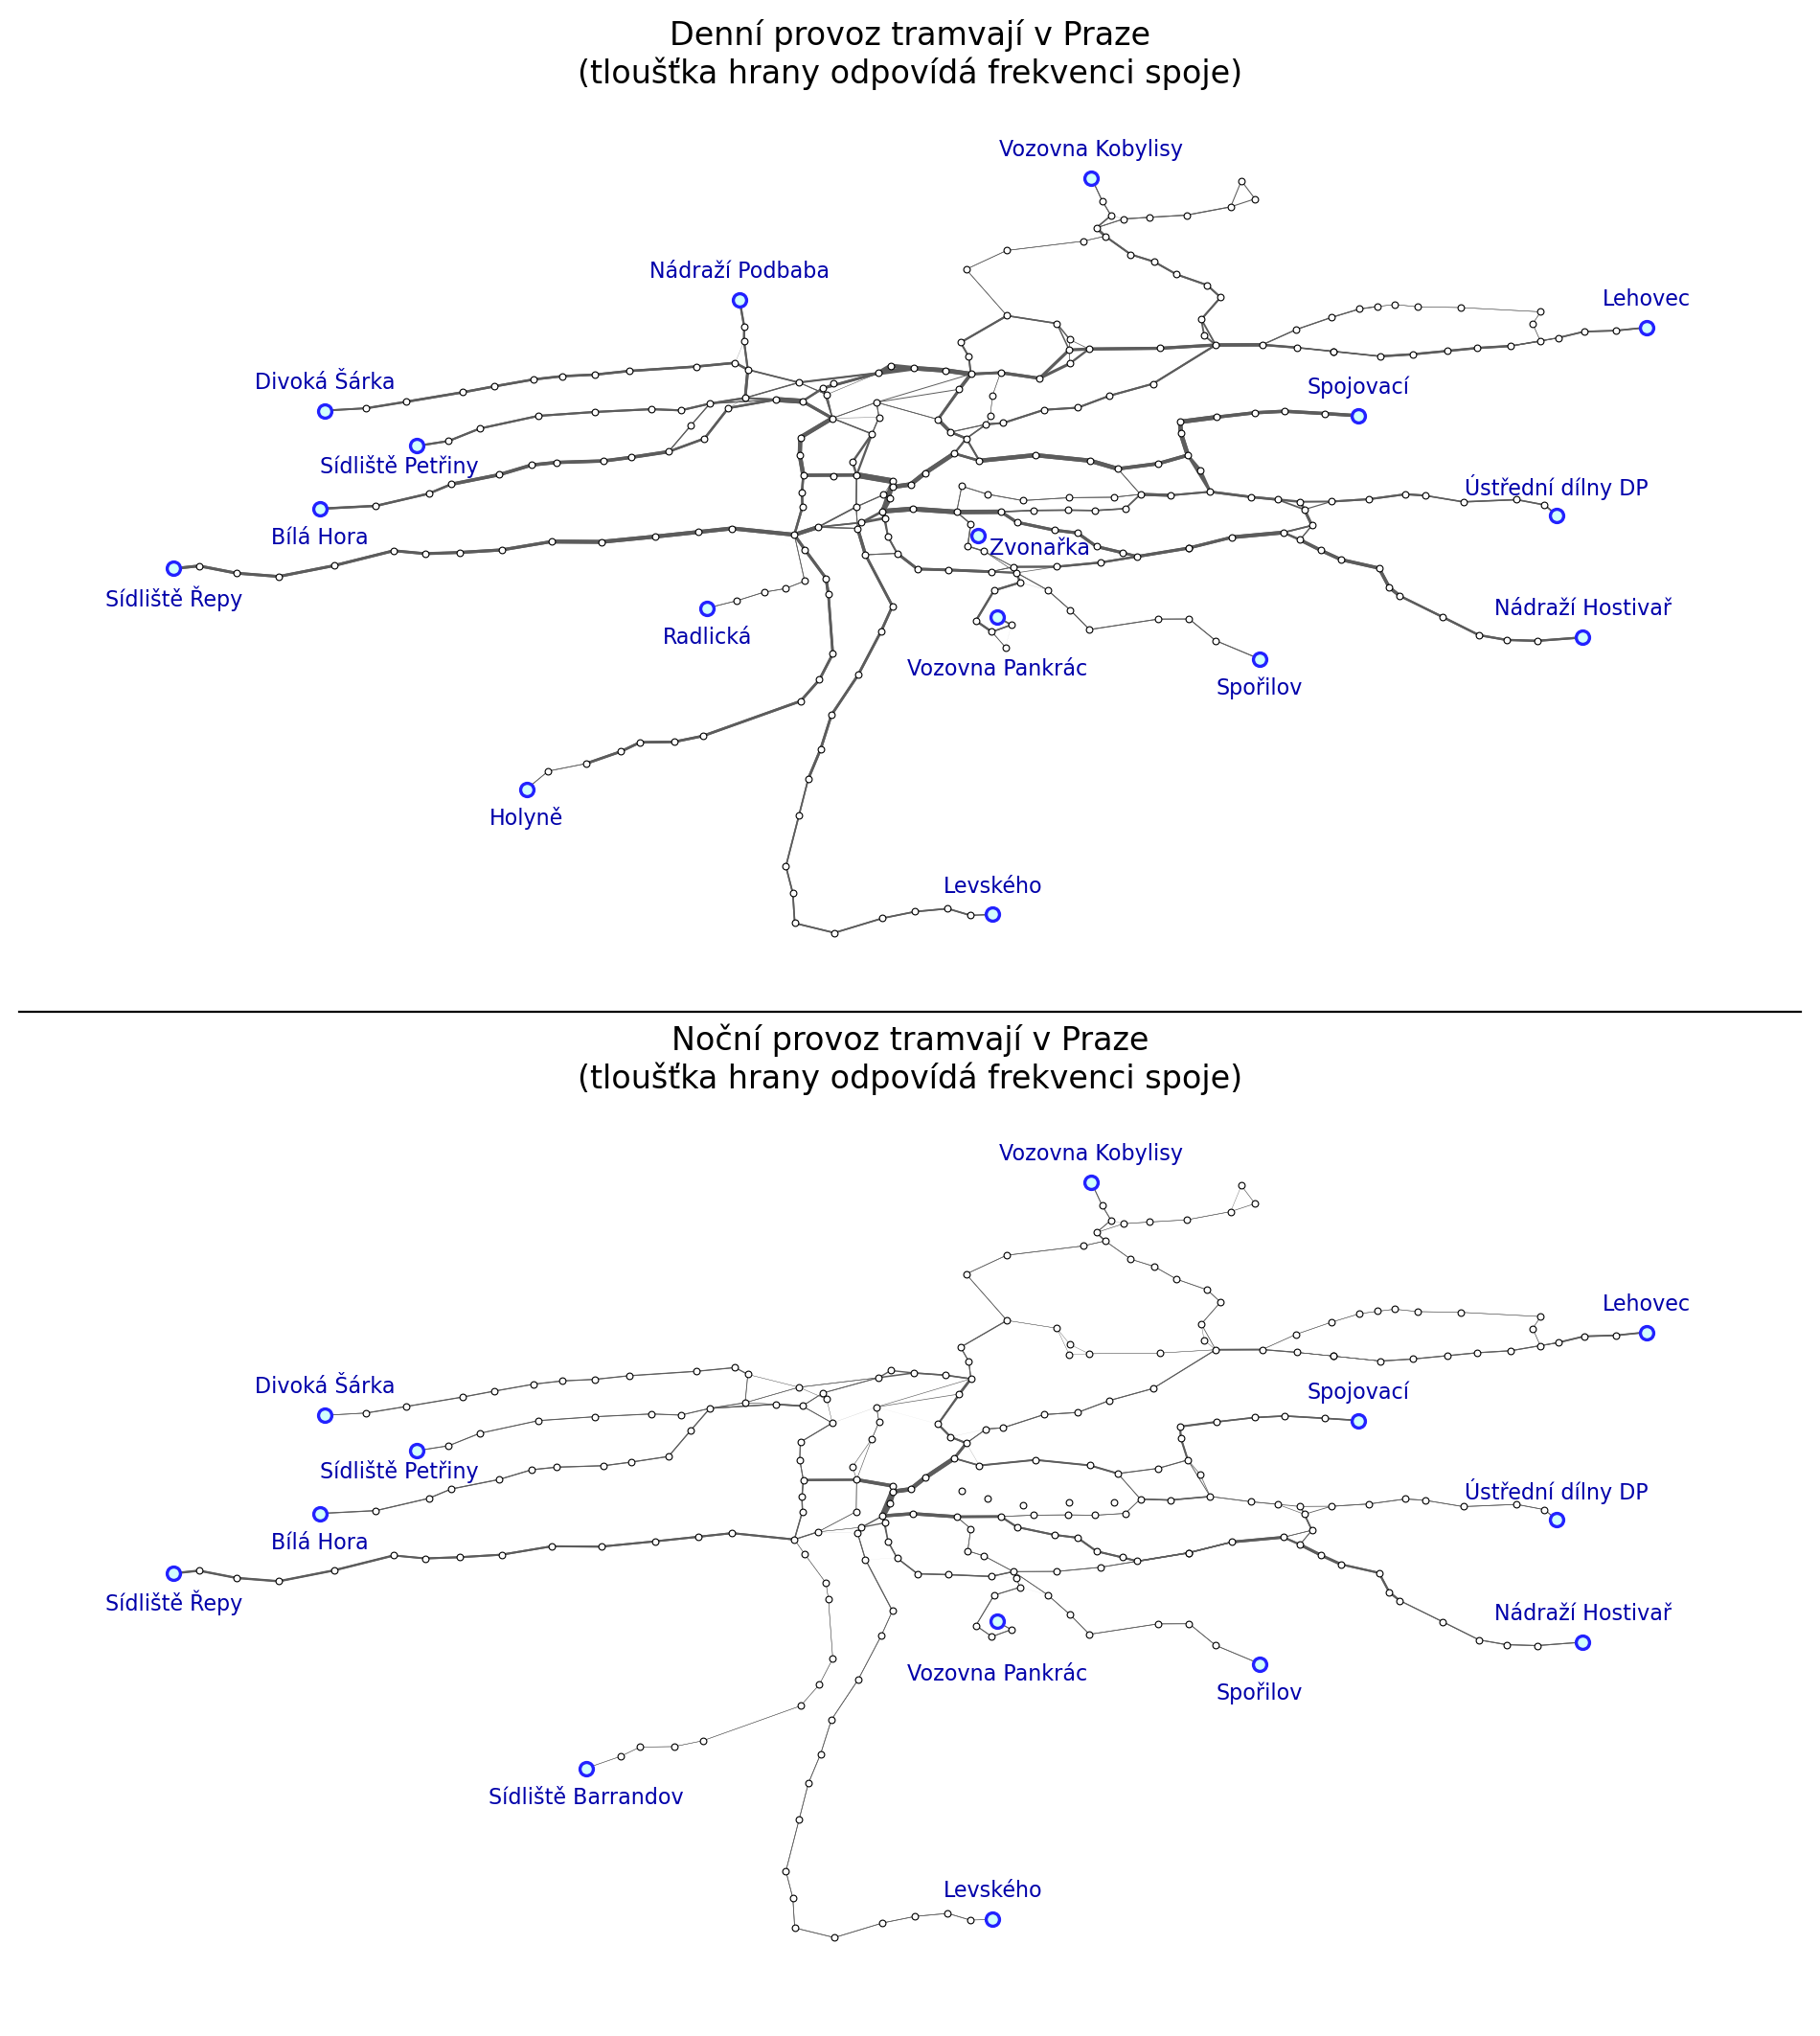

In [12]:
def draw_graph(G, title, ax):
    all_stops = set([name for name in G.nodes])
    final_stops = set([name for name, degree in G.in_degree if degree <= 1]).intersection(set([name for name, degree in G.out_degree if degree <= 1]))
    to_remove = []
    for stop in final_stops:
        if len(set(G.successors(stop)).union(set(G.predecessors(stop)))) >= 2:
            to_remove.append(stop)
    for stop in to_remove:
        final_stops.remove(stop)
    other_stops = all_stops.difference(final_stops)
    node_labels = {name: name for name in final_stops}
    
    edge_weights = [attr["weight"] for u, v, attr in G.edges(data=True)]
    min_weight, max_weight = min(edge_weights), max(edge_weights)
    edge_widths = [((weight - min_weight) / (max_weight - min_weight)) * 2.2 for weight in edge_weights]
    
    ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
    nx.draw_networkx_nodes(G, ax=ax, pos=vertex_pos, nodelist=other_stops, node_size=6, node_color="#ffffff", edgecolors="black", linewidths=0.4)
    nx.draw_networkx_nodes(G, ax=ax, pos=vertex_pos, nodelist=final_stops, node_size=25, node_color="#d1fffc", edgecolors="#2222ff", linewidths=1.2)
    nx.draw_networkx_edges(G, ax=ax, pos=vertex_pos, width=edge_widths, edge_color="#5c5c5c", node_size=6, arrows=False)
    nx.draw_networkx_labels(G, ax=ax, pos=labels_pos, labels=node_labels, font_size=8, font_color="#0000aa")
    ax.set_title(title);

fig = plt.figure(figsize=(12, 13))
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
gs.update(wspace=0.5, hspace=0.1)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
draw_graph(day_G, "Denní provoz tramvají v Praze\n(tloušťka hrany odpovídá frekvenci spoje)", ax1)
draw_graph(night_G, "Noční provoz tramvají v Praze\n(tloušťka hrany odpovídá frekvenci spoje)", ax2)
ax1.spines["bottom"].set_visible(True)

Můžeme si všimnout, že hrany na nočním grafu jsou tlusté jen mezi pár zastávkami v centru, jinak jsou užší, u denního grafu rozdíl není tak markantní. To znamená, že přes noc jezdí mimo centrum (vzhledem k množství tramvají v centru) ještě méně tramvají než přes den. Také si povšimněme, že graf nám v noci značně prořídnul. Některé stanice v nočním grafu vůbec nejsou, přes ty v noci tramvaj nejede, jde i o konečné zastávky Nádraží Podbaba, Radlická, Zvonařka, Holyně. Zato nám jedna konečná zastávka přibyla, a to Sídliště Barrandov (tramvaj nepokračuje dál).

## V jakou hodinu jezdí nejvíce tramvají?

Podívám se, v jakou hodinu (*arrive_to* xx:00:00 až xx:59:59) jezdí v praze nejvíce tramvají.

In [13]:
weekdays = ("monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday")
weekdays_cz = {"monday": "Pondělí", "tuesday": "Úterý", "wednesday": "Středa", "thursday": "Čtvrtek", "friday": "Pátek", "saturday": "Sobota", "sunday": "Neděle"}
tram_counts_by_hour = {
    "monday": [0] * 24,
    "tuesday": [0] * 24,
    "wednesday": [0] * 24,
    "thursday": [0] * 24,
    "friday": [0] * 24,
    "saturday": [0] * 24,
    "sunday": [0] * 24,
}

for idx, row in tram_df.iterrows():
    h, m, s = (int(x) for x in row["arrive_to"].split(":"))
    for day in weekdays:
        if row[day] == 1:
            tram_counts_by_hour[day][h] += 1

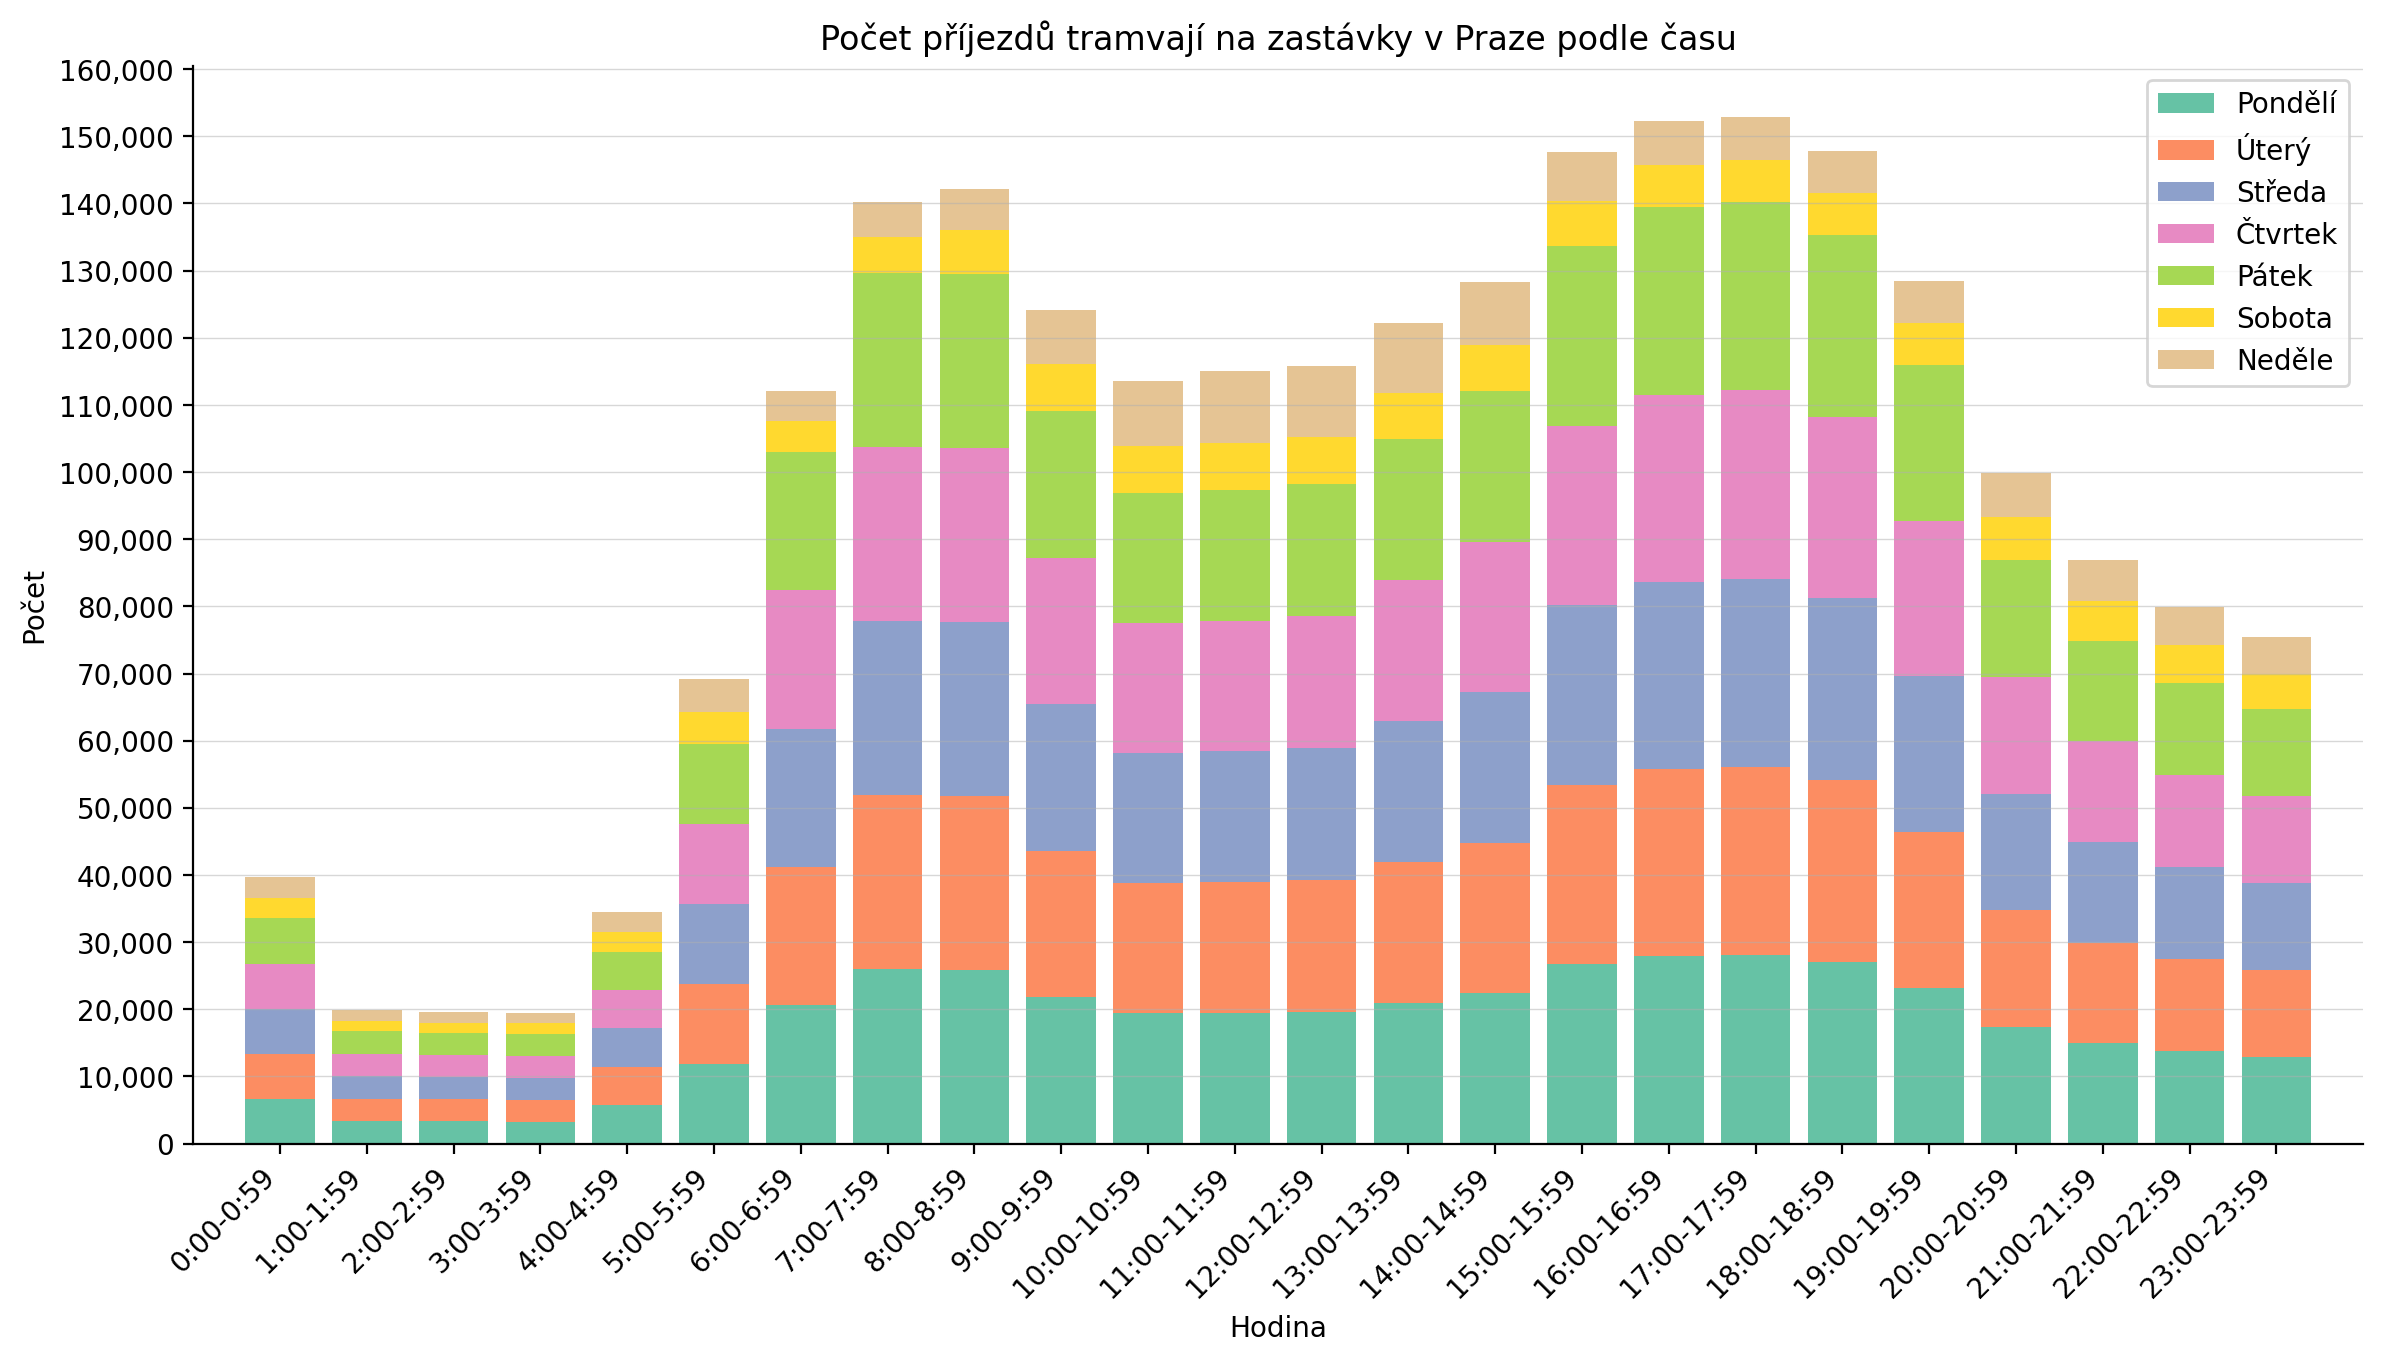

In [14]:
def num_to_hour_string(num, pos=0):
    return f"{num}:00-{num}:59"

def format_with_commas(x, pos=0):
    return f"{int(x):,}"

hours = np.arange(24)
data = np.array([tram_counts_by_hour[day] for day in weekdays])
counts_per_hour = np.sum(data, axis=0)

fig, ax = plt.subplots(figsize=(14, 7))
bottom = np.zeros(24)
for i, day in enumerate(weekdays):
    ax.bar(hours, data[i], bottom=bottom, label=weekdays_cz[day], color = cm.Set2.colors[i])
    bottom += data[i]

ax.spines[["top", "right"]].set_visible(False)
ax.set_xticks(hours)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(num_to_hour_string))
ax.yaxis.set_major_locator(ticker.MultipleLocator(10000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_with_commas))
for label in ax.get_xticklabels():
    label.set(rotation=45, ha="right")
ax.set_xlim((-1, 24))
ax.set_title("Počet příjezdů tramvají na zastávky v Praze podle času")
ax.grid(axis="y", alpha=0.5, linewidth=0.5)
ax.set_xlabel("Hodina")
ax.set_ylabel("Počet")
ax.legend();

Vidíme, že nejvíce tramvají jezdí mezi 15:00 a 19:00, to jezdí lidé z práce a ze školy. Pak také mezi 7:00 a 9:00, to lidé naopak jezdí do práce a do školy. Nejméně tramvají zase jezdí od půlnoci do páté hodiny ráno, to se dalo čekat. Navíc se zdá, že v každém sloupci jsou barevné bloky všedních dní rozloženy rovnoměrně. To znamená, že jezdí stejně tramvají v každý všední den ve stejnou dobu. Barevné bloky víkendových dnů jsou v každém sloupci menší oproti blokům všedních dnů, to znamená, že o víkendu jezdí méně tramvají.

## Jsou spoje z Malostranské stejně časté?

Viděli jsme, že Malostranská byla na prvním místě podle všech tří centralit. Jezdí z ní tramvaje do šesti zastávek. Jezdí jich ale stejně do každé z nich, nebo někam jezdí častěji než jinam? Závisí to i na tom, zda je všední den, nebo víkend?

In [15]:
print(f"Počet následníků Malostranské: {len(set(G.successors('Malostranská')))}")
malostranska_df = tram_df[tram_df["stop_from_name"] == "Malostranská"]
count_malostranska_df = malostranska_df[["stop_to_name", *weekdays, "num_days"]].groupby(["stop_to_name"]).sum()
count_malostranska_df

Počet následníků Malostranské: 6


,monday,tuesday,wednesday,thursday,friday,saturday,sunday,num_days
stop_to_name,,,,,,,,
Chotkovy sady,445,445,445,445,445,0,0,2225
Hradčanská (ul. Badeniho),266,266,266,266,266,142,187,1659
Královský letohrádek,875,875,875,875,875,293,267,4935
Malostranské náměstí,1361,1361,1361,1361,1361,429,449,7683
Staroměstská,452,452,452,452,452,138,144,2542
Čechův most,237,237,237,237,237,75,83,1343


Vidím, že počet tramvají, které odjedou z Malostranské na nějakou zastávku jsou ve všedních dnech stejné, v sobotu a v neděli jsou podobné. Nakreslím koláčové grafy, které nám umožní porovnat, na jaké zastávky jezdí více tramvají z Malostranské ve všední dny a o víkendu.

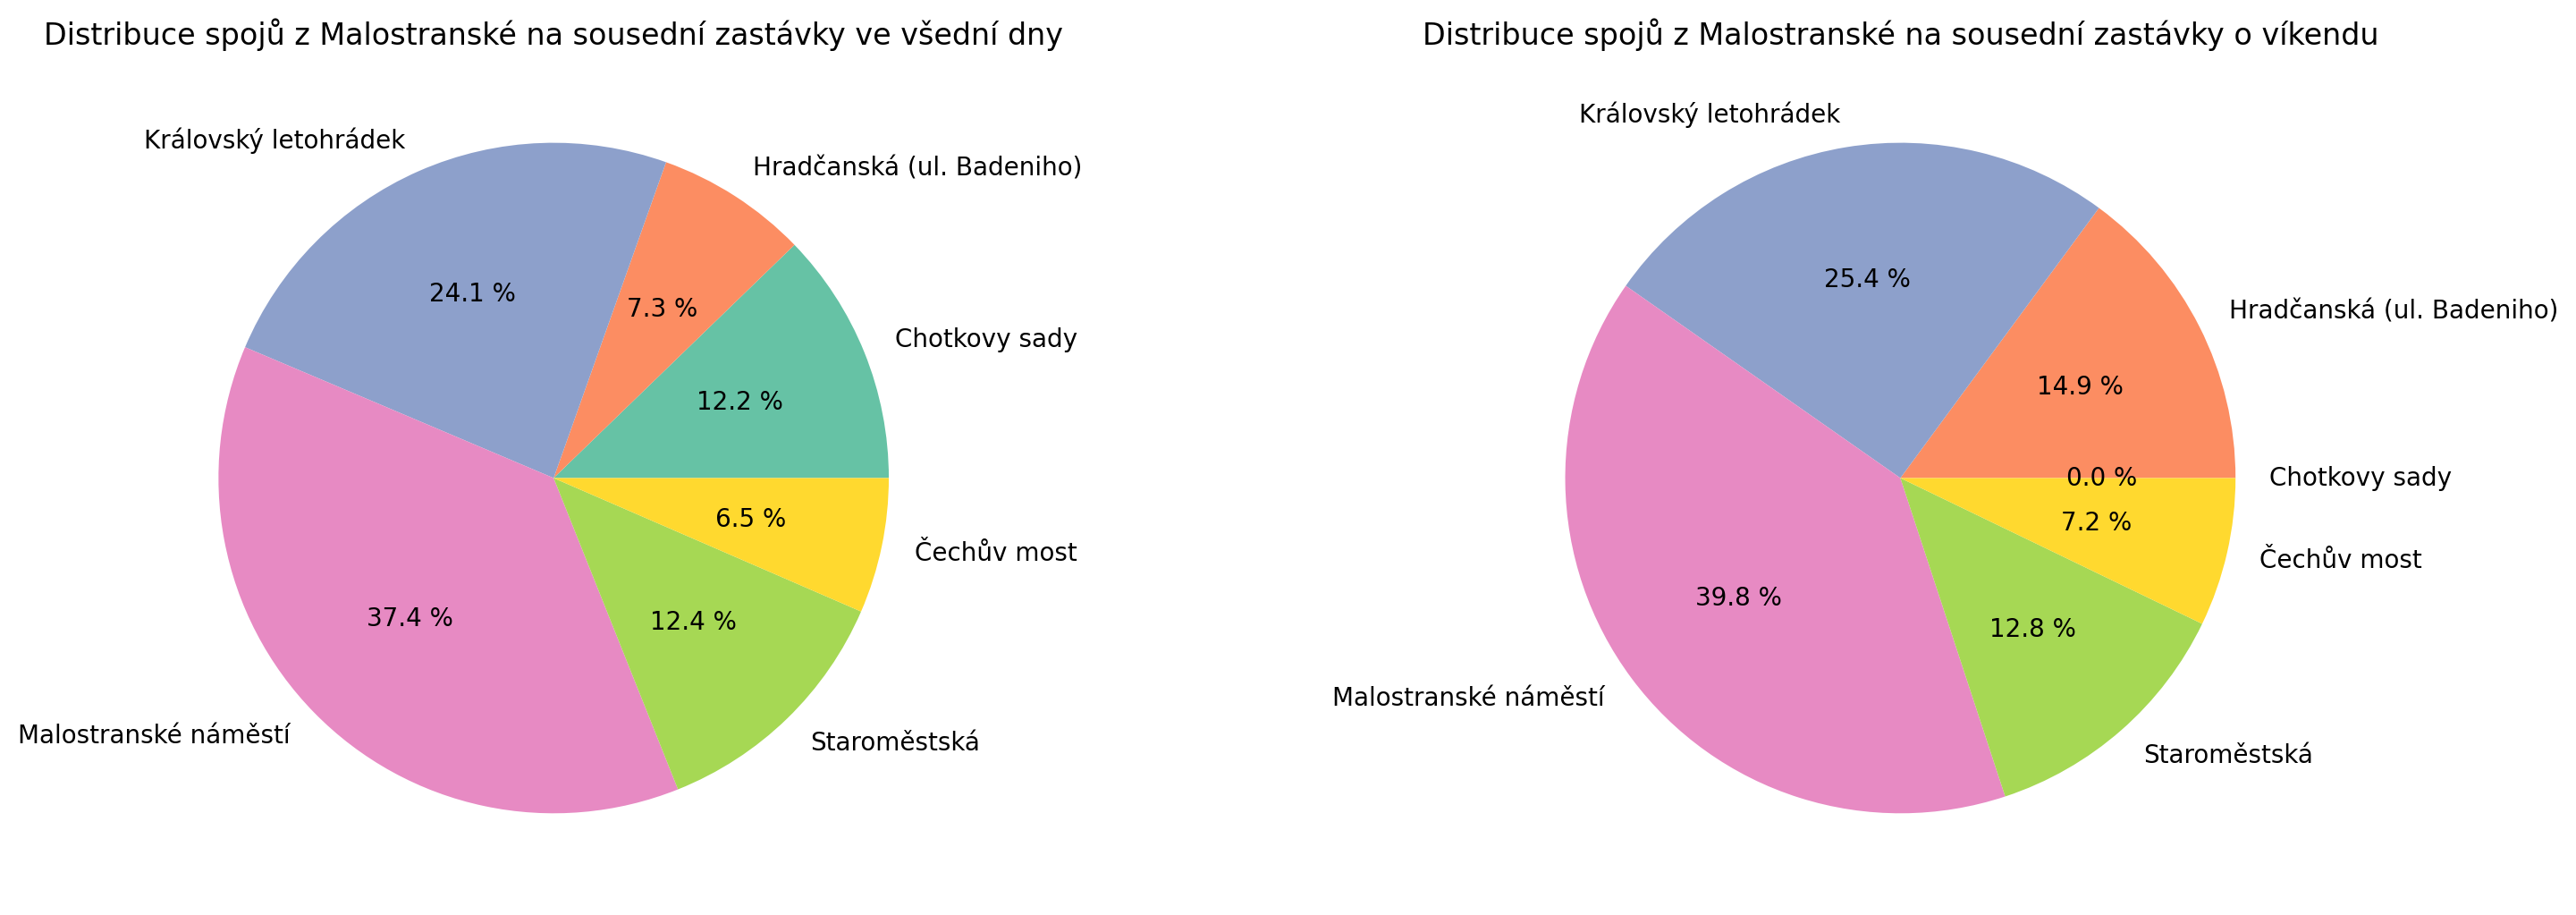

In [16]:
fig = plt.figure(figsize=(15, 5), constrained_layout=True)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.pie(count_malostranska_df["monday"], labels=count_malostranska_df.index, autopct='%1.1f %%', colors=cm.Set2.colors)
ax1.set_title("Distribuce spojů z Malostranské na sousední zastávky ve všední dny")
ax2.pie(count_malostranska_df[["saturday", "sunday"]].sum(axis=1), labels=count_malostranska_df.index, autopct='%1.1f %%', colors=cm.Set2.colors)
ax2.set_title("Distribuce spojů z Malostranské na sousední zastávky o víkendu");

Na různé zastávky z Malostranské rozhodně nejezdí stejně tramvají ani ve všední dny ani o víkendu. Nejvíce tramvají jezdí na Malostranské náměstí a na Královský letohrádek. Pak si ale můžeme všimnout jistých rozdílů mezi víkendem a všedními dny. Např. do stanice Chotkovy sady o víkendu tramvaje z Malostranské vůbec nejezdí, zato do stanice Hradčanská (ul. Badeniho) jezdí o víkendu 14.9 % tramvají oproti 7.3 % ve všední dny.

# Závěr

Zpracoval jsem dataset a zaměřil jsem se na tramvaje v Praze. Vykreslil jsem graf tramvajové sítě a odpověděl na otázky. Některá zjištění jsem předpokládal, ale jiná mě překvapila.